## Online distributed waveform-synchronization for acoustic sensor networks with dynamic topology: Demo
#### (A. Chinaev, N. Knäpper \& G. Enzner)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from lazy_dataset.database import JsonDatabase
from paderbox.io import load_audio

from modules.plot_utils import *
from modules.audio_reader import AudioReader # customized, previously part of asn_testbed
from modules.sro_estimation import NetworkController
from modules.topology_tools import TopologyManager

from simulation_3_evaluate import evaluate_simulation_results, get_rto

## 1. Demo configuration

In [4]:
DATA_ROOT = 'data/' # signal database incl. metadata

sig_len_sec = 300
fs_Hz = 16e3
frame_len = 2**11
testbed_json = DATA_ROOT+'json/testbed.json'
json_pos = DATA_ROOT+'json/positions.json'
room_model = DATA_ROOT+'room_model.stl'
n_frames = int((sig_len_sec*fs_Hz)/frame_len) 
example_db = JsonDatabase(testbed_json)
examples = example_db.get_dataset('examples')
ex_id = 0
node_coord = lambda nid: examples[ex_id]['nodes']["node_"+str(nid)]['position']['coordinates']
node_sro = lambda nid: examples[ex_id]['nodes'][nid]['sro']


### Configuration of WASN topology and network change

Initial WASN and its modification (a) appearance of a new node


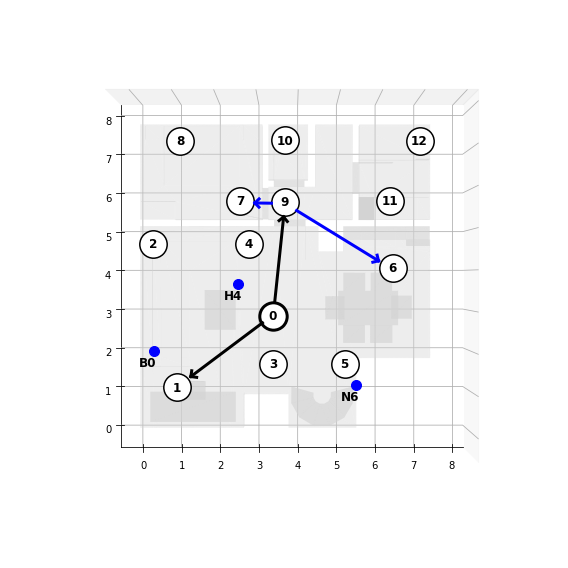

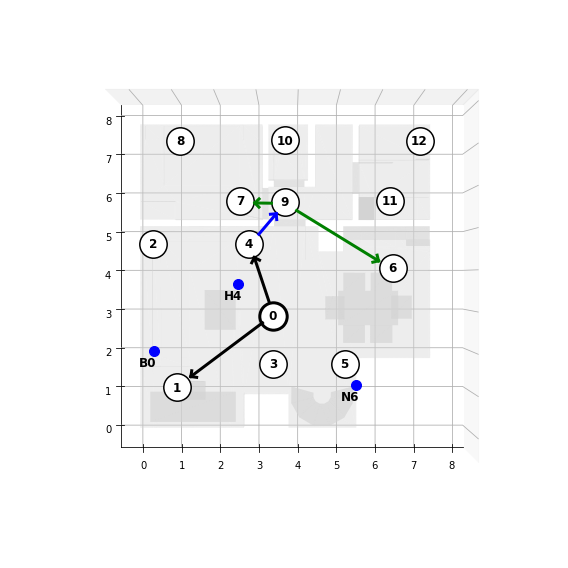

In [5]:
# Choose participating nodes in initial WASN
node_ids_start = [0, 1, 6, 7, 9]

# Define time of network change
Tc_sec = 200

# Obtain initial topology
TopMng = TopologyManager({nid: node_coord(nid) for nid in node_ids_start})
nodes_levels_before = TopMng.nodes_levels

# Configure network modification
network_mod_type = 1

if network_mod_type == 1:
    mod_type_string = "(a) appearance of a new node"
    TopMng.add_nodes({4: node_coord(4)})
elif network_mod_type == 2:
    mod_type_string = "(b) failure of a communication link"
    TopMng.set_node_links([[6, 9]], False)
elif network_mod_type == 3:
    mod_type_string = "(c) failure of a non-reference sensor node"
    TopMng.remove_nodes([1])
elif network_mod_type == 4:
    mod_type_string = "(d) failure of the reference sensor node"
    TopMng.remove_nodes([0])
else:
    raise Exception('Choose a valid value for type_of_network_modification.')
nodes_levels_after = TopMng.nodes_levels

# Determine selection masks...
nodes_select = TopologyManager.get_unique_node_list(nodes_levels_before+nodes_levels_after)
nodes_select_before = TopologyManager.get_unique_node_list(nodes_levels_before)
nodes_select_after = TopologyManager.get_unique_node_list(nodes_levels_after)
n_nodes = len(nodes_select)
n_async_nodes = n_nodes-1
select_before = [nodes_select.index(node_id) for node_id in nodes_select_before]
select_after = [nodes_select.index(node_id) for node_id in nodes_select_after]

# Plot topology before and after network change
print("Initial WASN and its modification " + mod_type_string)
plot_positions_and_topology(examples[ex_id], room_model, sig_len_sec, nodes_levels_before)
plot_positions_and_topology(examples[ex_id], room_model, sig_len_sec, nodes_levels_after)

## 2. Loading of Audio- and Metadata

In [6]:
# LOAD AUDIO
audio_reader = AudioReader(data_root=DATA_ROOT, block_length=frame_len, block_shift=frame_len, node_ids=nodes_select, mic_ids='mic_0')
examples = examples.map(audio_reader)

frame_len = np.shape(examples[ex_id]['audio'][nodes_select[0]]['mic_0'])[1]
n_frames_max = min([np.shape(examples[ex_id]['audio'][node_id]['mic_0'])[0] for node_id in nodes_select])
n_frames = int((sig_len_sec*fs_Hz)/frame_len) 
if n_frames > n_frames_max:
    n_frames = n_frames_max
    sig_len_prev = sig_len_sec
    sig_len_sec = n_frames*frame_len/fs_Hz
    print('Warning: Audio signals too short for desired simulation length of ', str(sig_len_prev), 's. \nReduced simulation length to ', str(sig_len_sec), 's')
signals = np.stack(tuple(examples[ex_id]['audio'][node]['mic_0'][:n_frames,:] for node in nodes_select), axis=2)

# GET GROUND TRUTH SRO (AND STO)
SRO_true = np.zeros((n_nodes))
for i in range(1, len(nodes_select)):
    #SRO_true[i] = examples[ex_id]['nodes'][nodes_select[i]]['sro'] - examples[ex_id]['nodes'][nodes_select[0]]['sro']
    SRO_true[i] = node_sro(nodes_select[i]) - node_sro(nodes_select[0])

SRO_ref = node_sro(nodes_select_before[0]) # used for eval

### Visualization of source activity and scene diary

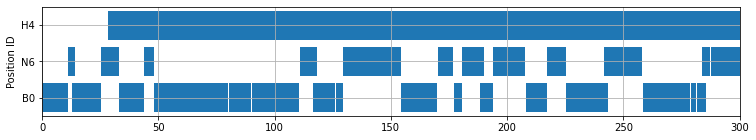

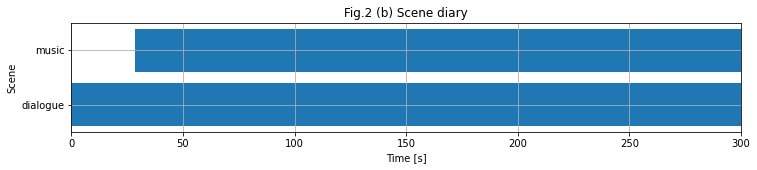

In [7]:
plot_pos_hist(examples[ex_id]['src_diary'], sig_len_sec)
plot_scene_diary(examples[ex_id]['scene_diary'], sig_len_sec)

## 3. Dynamic WASN simulation and evaluation results

In [8]:
# Prepare results
signals_synced = np.zeros_like(signals)
signals_synced[:,:,0] = signals[:,:,0] # ref signal is already sync
SRO_est = np.empty((n_frames, n_nodes))
SRO_est[:] = np.nan
dSRO_est = np.empty((n_frames, n_nodes))
dSRO_est[:] = np.nan


# Simulate WASN operation...
Net = NetworkController(nodes_levels_before, frame_len, resamplerType='stft')
Tc_frame_idx = int(np.round(Tc_sec*fs_Hz/frame_len))
n_frames = np.shape(signals)[0]
resamplerDelay = Net.resampler_delay
print('WASN processing before network change...')

for frame_idx in tqdm(range(n_frames)):

    if frame_idx == Tc_frame_idx:
        Net.restructure(nodes_levels_after)
        print('WASN processing after modification!')

    select = select_before if frame_idx < Tc_frame_idx else select_after
    select_out = select

    SRO_est_, dSRO_est_, frames_synced = Net.process(signals[frame_idx, :, select].T)
    SRO_est[frame_idx, select_out] = SRO_est_
    dSRO_est[frame_idx, select_out] = dSRO_est_

    signals_synced[frame_idx,:,0] = signals[frame_idx, :, 0] # from root node
    signals_synced[frame_idx,:, select] = frames_synced.T

Net.shutdown()

WASN processing before network change...


 67%|██████▋   | 1570/2343 [00:25<00:12, 62.03it/s]

WASN processing after modification!


100%|██████████| 2343/2343 [00:38<00:00, 60.56it/s]


### 3.1. Visualization of SRO trajectories

SRO trajectories for (a) appearance of a new node occurred at


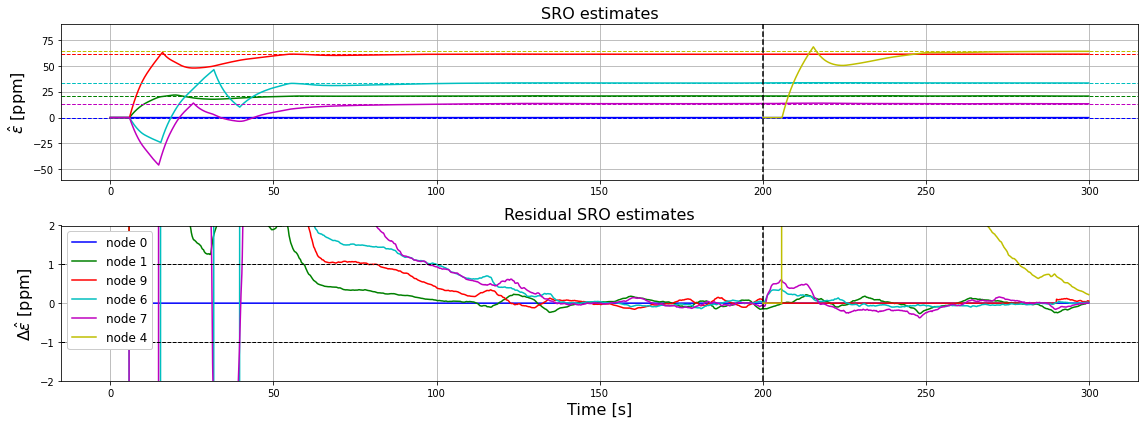

In [9]:
print("SRO trajectories for " + mod_type_string + " occurred at" )
colors = ['b', 'g', 'r', 'c', 'm', 'y']
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

for i in range(n_nodes):
    mask = np.isfinite(SRO_est[:,i])
    time_ax = np.arange(len(SRO_est[:,i]))*(frame_len/fs_Hz)
    axs[0].plot(time_ax[mask], SRO_est[mask,i], label=' '.join(nodes_select[i].split('_')), color=colors[i%len(colors)])
    axs[0].axhline(y=SRO_true[i], linestyle='--', color=colors[i%len(colors)], lw=1)
axs[0].set_title('SRO estimates', fontsize=16)
axs[0].set_ylabel(r'$\hat{\varepsilon}$ [ppm]', fontsize=16)
axs[0].set_ylim((-60, 90))       
axs[0].grid()
axs[0].axvline(x=Tc_sec, linestyle='--', color='k') 


for i in range(n_nodes):
    mask = np.isfinite(dSRO_est[:,i]) 
    time_ax = np.arange(len(dSRO_est[:,i]))*(frame_len/fs_Hz)
    axs[1].plot(time_ax[mask], dSRO_est[mask,i], label=' '.join(nodes_select[i].split('_')), color=colors[i%len(colors)])
axs[1].legend(loc='upper left', fontsize=12, framealpha=1)
axs[1].set_title('Residual SRO estimates', fontsize=16)
axs[1].axhline(-1, linestyle='--', color='k', lw=1)
axs[1].axhline(1, linestyle='--', color='k', lw=1)
axs[1].set_ylabel(r'$\Delta\hat{\varepsilon}$ [ppm]', fontsize=16)
axs[1].set_ylim((-2, 2)); axs[1].grid()
axs[-1].set_xlabel('Time [s]', fontsize=16)
axs[1].axvline(x=Tc_sec, linestyle='--', color='k') 

plt.tight_layout(); 
plt.show()

### 3.2. Evaluation results

In [10]:
# Load sync signals for reference
signals_sync = np.zeros((n_frames, frame_len, n_nodes))
for i, node_id in enumerate(nodes_select):
    signal_sync = load_audio(DATA_ROOT+'audio/example_0_sync/'+node_id+'_mic_0.wav')[0:(n_frames*frame_len)]
    signals_sync[:,:,i] = np.reshape(signal_sync, (n_frames, frame_len))


# determine individual signal offsets 
signalsSelect_before = [nodes_select.index(nid) for nid in nodes_select_before]
signalsSelect_after = [nodes_select.index(nid) for nid in nodes_select_after]

node_level_positions_before = TopologyManager.get_node_level_positions(nodes_levels_before)
node_level_positions_after = TopologyManager.get_node_level_positions(nodes_levels_after)
node_signals_offset_before = {nid_str: (lid+1)*resamplerDelay for nid_str, lid in node_level_positions_before.items()}
node_signals_offset_after = {nid_str: (lid+1)*resamplerDelay for nid_str, lid in node_level_positions_after.items()}

# Separete "before" and "after" signal segments
signals_synced_before = signals_synced[:Tc_frame_idx,:,:]
n_frames_before = np.shape(signals_synced_before)[0]
signals_synced_after = signals_synced[Tc_frame_idx+1:,:,:]
n_frames_after = np.shape(signals_synced_after)[0]

# Align output signals separately for both segments: compensate offset
for nid, offset in node_signals_offset_before.items():
    idx = nodes_select.index(nid)
    signals_synced_before[:(n_frames_before-offset),:,idx] = signals_synced_before[offset:,:,idx]
for nid, offset in node_signals_offset_after.items():
    idx = nodes_select.index(nid)
    signals_synced_after[:(n_frames_after-offset),:,idx] = signals_synced_after[offset:,:,idx]


#### 3.2.1. Simulation results for "before"

In [11]:
# evaluate simulation results for "before"
eval_res_before = {'rmse_t': [], 'rmse': [], 'ssnr': [], 'ssnr_async': [], 'amsc': [], 'amsc_async': [], 'Tc_sec': []}
eval_res_before['rmse_t'], eval_res_before['rmse'], eval_res_before['ssnr'], eval_res_before['ssnr_async'], eval_res_before['amsc'], eval_res_before['amsc_async'], eval_res_before['Tc_sec'] = \
evaluate_simulation_results(
        None, 
        fs_Hz, 
        frame_len, 
        SRO_est[:Tc_frame_idx, signalsSelect_before], 
        SRO_true[signalsSelect_before],  
        SRO_ref,
        signals[:Tc_frame_idx,:,signalsSelect_before], 
        signals_synced[:Tc_frame_idx,:,signalsSelect_before], 
        signals_sync[:Tc_frame_idx,:,signalsSelect_before], 
        verbose = False,
        ref_node_idx = 0, #index of reference node w.r.t. all provided arrays
        eval_idx_range = None, #frame index range of results to evaluate. Default (None) -> last 10 seconds
        rto_add = None, # additional RTO to add to the locally calculated RTO. (i.e. from preceding signal-segments)
        SRO_add = 0, # added to all SRO estimates
)

#### 3.2.2. Simulation results for "after"

In [12]:
# Calculate additional RTO up until time of network-change to consider in evaluation of "after" segment
rto_add = []
rto_add_joined = 0
for node_idx in signalsSelect_after:
        if node_idx not in signalsSelect_before:
                #joining nodes carry inherent RTO due to lack of resampling during "before" period
                # but only relevant for "joined-only" eval, not "after" eval.
                rto_add.append(0) 
                rto_add_joined = (SRO_est[-1, node_idx]+SRO_ref)*Tc_frame_idx*1e-6*frame_len
                continue
        rto_add_late_ = SRO_ref*Tc_frame_idx*1e-6*frame_len #b.c. additional resampling for SRO_ref starts only at frame_idx_switch
        rto_add.append(get_rto(SRO_est[:Tc_frame_idx, node_idx], frame_len) + rto_add_late_) 

eval_res_after = {'rmse_t': [], 'rmse': [], 'ssnr': [], 'ssnr_async': [], 'amsc': [], 'amsc_async': [], 'Tc_sec': []}
eval_res_after['rmse_t'], eval_res_after['rmse'], eval_res_after['ssnr'], eval_res_after['ssnr_async'], eval_res_after['amsc'], eval_res_after['amsc_async'], eval_res_after['Tc_sec'] =  \
evaluate_simulation_results(
        None, 
        fs_Hz, 
        frame_len, 
        SRO_est[Tc_frame_idx+1:, signalsSelect_after], 
        SRO_true[signalsSelect_after],  
        SRO_ref,
        signals[Tc_frame_idx+1:,:,signalsSelect_after], 
        signals_synced[Tc_frame_idx+1:,:,signalsSelect_after], 
        signals_sync[Tc_frame_idx+1:,:,signalsSelect_after], 
        verbose = False,
        ref_node_idx = 0, #index of reference node w.r.t. all provided arrays
        eval_idx_range = range(0, int(10*fs_Hz/frame_len)), #frame index range of results to evaluate. Default (None) -> last 10 seconds
        rto_add = rto_add, # additional RTO to add to the locally calculated RTO. (i.e. from preceding signal-segments)
        SRO_add = 0, # added to all SRO estimates
)

### 3.3 Visualization of evaluation results

Resulting RMSE-SRO, AMSC and SSRN values for (a) appearance of a new node


/home/niklas/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:4575: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


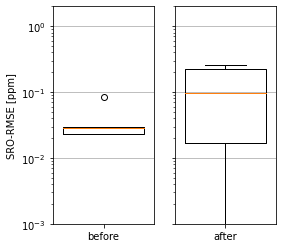

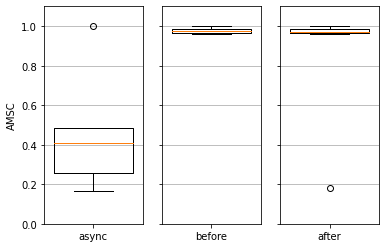

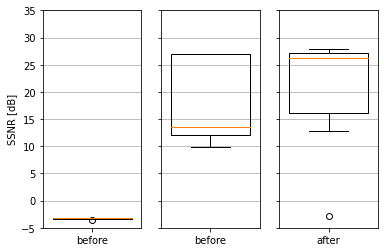

In [45]:
print("Resulting RMSE-SRO, AMSC and SSRN values for " + mod_type_string)

# Plot: RMSE
f, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=[4, 4])

ax[0].boxplot(eval_res_before['rmse'], 

                notch=False,
                vert=True,
                widths=0.8
)
ax[0].set_yscale('log')
ax[0].set_ylim((1e-3, 2))
ax[0].set_ylabel('SRO-RMSE [ppm]')
ax[0].set_xticks((1,), ('before',))
ax[0].grid(axis='y')

ax[1].boxplot(eval_res_after['rmse'], 
                notch=False,
                vert=True,
                widths=0.8
)
ax[1].set_yscale('log')
ax[1].set_ylim((1e-3, 2))
ax[1].set_xticks((1,), ('after',))
ax[1].set_yticks((1e-3, 1e-2, 1e-1, 1), ("", "", "", ""))
ax[1].grid(axis='y')

#Plot: AMSC
f, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]}, figsize=[6, 4])

ax[0].boxplot(eval_res_before['amsc_async'], 
                notch=False,
                vert=True,
                widths=0.8
)
ax[0].set_xticks((1,), ('async',))
ax[0].set_ylim((0, 1.1))
ax[0].set_ylabel('AMSC')
ax[0].grid(axis='y')

ax[1].boxplot(eval_res_before['amsc'], 
                notch=False,
                vert=True,
                widths=0.8
)
ax[1].set_xticks((1,), ('before',))
ax[1].set_ylim((0, 1.1))
ax[1].grid(axis='y')
ax[1].set_yticks((0, 0.2, 0.4, 0.6, 0.8, 1), ("", "", "", "", "", ""))

ax[2].boxplot(eval_res_after['amsc'], 
                notch=False,
                vert=True,
                widths=0.8
)
ax[2].set_xticks((1,), ('after',))
ax[2].set_ylim((0, 1.1))
ax[2].grid(axis='y')
ax[2].set_yticks((0, 0.2, 0.4, 0.6, 0.8, 1), ("", "", "", "", "", ""))

# Plot: SSNR
f, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]}, figsize=[6, 4])


ax[0].boxplot(eval_res_before['ssnr_async'], 
                notch=False,
                vert=True,
                widths=0.8
)
ax[0].set_xticks((1,), ('async',))

ax[0].set_ylim((-5, 35))
ax[0].set_ylabel('SSNR [dB]')
ax[0].grid(axis='y')

ax[1].boxplot(eval_res_before['ssnr'], 
                notch=False,
                vert=True,
                widths=0.8
)
ax[1].set_xticks((1,), ('before',))
ax[1].set_yticks((-5,0,5,10,15,20,25,30,35), ("","","","","","","","",""));
ax[1].grid(axis='y')
ax[1].set_ylim((-5, 35))

ax[2].boxplot(eval_res_after['ssnr'], 
                notch=False,
                vert=True,
                widths=0.8
)
ax[2].set_xticks((1,), ('after',))
ax[2].set_ylim((-5, 35))
ax[2].set_yticks((-5,0,5,10,15,20,25,30,35), ("","","","","","","","",""));
ax[2].grid(axis='y')